# Regularization and Evaluation of Neural Networks

In [1]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.confusion import plot_confusion_matrix
    
%load_ext autoreload
%autoreload 2

## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [2]:
digits = load_digits()
X = digits.data.astype('float32')
y = digits.target.astype('float32')

y_binary = y % 2

In [3]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Metal device set to: Apple M1 Pro


2022-09-09 12:02:42.892156: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-09 12:02:42.892312: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2022-09-09 12:02:43.533181: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-09 12:02:43.843634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


180/180 [==============================] - 4s 8ms/step - loss: 0.4794 - accuracy: 0.7963
Epoch 2/50
180/180 [==============================] - 1s 6ms/step - loss: 0.2631 - accuracy: 0.8893
Epoch 3/50
180/180 [==============================] - 1s 6ms/step - loss: 0.2105 - accuracy: 0.9165
Epoch 4/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1748 - accuracy: 0.9243
Epoch 5/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1517 - accuracy: 0.9377
Epoch 6/50
180/180 [==============================] - 1s 7ms/step - loss: 0.1350 - accuracy: 0.9427
Epoch 7/50
180/180 [==============================] - 1s 7ms/step - loss: 0.1220 - accuracy: 0.9499
Epoch 8/50
180/180 [==============================] - 1s 7ms/step - loss: 0.1115 - accuracy: 0.9622
Epoch 9/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1037 - accuracy: 0.9599
Epoch 10/50
180/180 [==============================] - 1s 6ms/step - loss: 0.0916 - accuracy: 0.9644
Epoch 11/5

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling

**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [4]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

In [5]:
X_pure_train

array([[0.    , 0.    , 0.    , ..., 0.875 , 0.    , 0.    ],
       [0.    , 0.    , 0.125 , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.375 , ..., 0.1875, 0.    , 0.    ],
       [0.    , 0.    , 0.625 , ..., 0.8125, 1.    , 0.5   ],
       [0.    , 0.    , 0.25  , ..., 0.0625, 0.    , 0.    ]],
      dtype=float32)

### Sigmoid 

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [6]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10


2022-09-09 12:05:03.872751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 9ms/step - loss: 0.7338 - accuracy: 0.4961
Epoch 2/10
12/12 [==============================] - 0s 5ms/step - loss: 0.7253 - accuracy: 0.4961
Epoch 3/10
12/12 [==============================] - 0s 6ms/step - loss: 0.7186 - accuracy: 0.4961
Epoch 4/10
12/12 [==============================] - 0s 6ms/step - loss: 0.7137 - accuracy: 0.4961
Epoch 5/10
12/12 [==============================] - 0s 6ms/step - loss: 0.7096 - accuracy: 0.4961
Epoch 6/10
12/12 [==============================] - 0s 6ms/step - loss: 0.7064 - accuracy: 0.4961
Epoch 7/10
12/12 [==============================] - 0s 6ms/step - loss: 0.7040 - accuracy: 0.4961
Epoch 8/10
12/12 [==============================] - 0s 6ms/step - loss: 0.7020 - accuracy: 0.4961
Epoch 9/10
12/12 [==============================] - 0s 6ms/step - loss: 0.7004 - accuracy: 0.4961
Epoch 10/10
12/12 [==============================] - 0s 6ms/step - loss: 0.6991 - accuracy: 0.4961


We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [7]:
# dict
results.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x16c08b280>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.7337661385536194,
   0.7252822518348694,
   0.7186113595962524,
   0.7137392163276672,
   0.7095780372619629,
   0.7063804864883423,
   0.7040292620658875,
   0.7020004987716675,
   0.7003644108772278,
   0.6991406679153442],
  'accuracy': [0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [8]:
results.history

{'loss': [0.7337661385536194,
  0.7252822518348694,
  0.7186113595962524,
  0.7137392163276672,
  0.7095780372619629,
  0.7063804864883423,
  0.7040292620658875,
  0.7020004987716675,
  0.7003644108772278,
  0.6991406679153442],
 'accuracy': [0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434]}

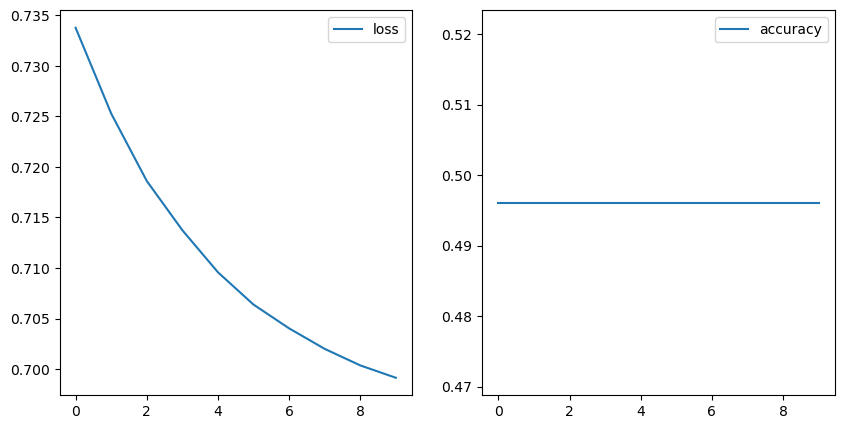

In [9]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

## Basic Model Tuning

### Increase Epochs

In [10]:
model = Sequential()
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs

results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=100, verbose=1)


Epoch 1/100
12/12 [==============================] - 0s 9ms/step - loss: 0.7337 - accuracy: 0.4961
Epoch 2/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6986 - accuracy: 0.5600

2022-09-09 12:08:49.621498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 6ms/step - loss: 0.7253 - accuracy: 0.4961
Epoch 3/100
12/12 [==============================] - 0s 7ms/step - loss: 0.7188 - accuracy: 0.4961
Epoch 4/100
12/12 [==============================] - 0s 7ms/step - loss: 0.7135 - accuracy: 0.4961
Epoch 5/100
12/12 [==============================] - 0s 6ms/step - loss: 0.7095 - accuracy: 0.4961
Epoch 6/100
12/12 [==============================] - 0s 6ms/step - loss: 0.7064 - accuracy: 0.4961
Epoch 7/100
12/12 [==============================] - 0s 6ms/step - loss: 0.7040 - accuracy: 0.4961
Epoch 8/100
12/12 [==============================] - 0s 6ms/step - loss: 0.7022 - accuracy: 0.4961
Epoch 9/100
12/12 [==============================] - 0s 6ms/step - loss: 0.7005 - accuracy: 0.4961
Epoch 10/100
12/12 [==============================] - 0s 6ms/step - loss: 0.6994 - accuracy: 0.4961
Epoch 11/100
12/12 [==============================] - 0s 6ms/step - loss: 0.6984 - accuracy: 0.4961
Epoch 12/100
12/12 [

12/12 [==============================] - 0s 6ms/step - loss: 0.6837 - accuracy: 0.7067
Epoch 85/100
12/12 [==============================] - 0s 6ms/step - loss: 0.6836 - accuracy: 0.7058
Epoch 86/100
12/12 [==============================] - 0s 6ms/step - loss: 0.6834 - accuracy: 0.7067
Epoch 87/100
12/12 [==============================] - 0s 6ms/step - loss: 0.6832 - accuracy: 0.7067
Epoch 88/100
12/12 [==============================] - 0s 6ms/step - loss: 0.6831 - accuracy: 0.7128
Epoch 89/100
12/12 [==============================] - 0s 7ms/step - loss: 0.6829 - accuracy: 0.7119
Epoch 90/100
12/12 [==============================] - 0s 6ms/step - loss: 0.6827 - accuracy: 0.7163
Epoch 91/100
12/12 [==============================] - 0s 6ms/step - loss: 0.6826 - accuracy: 0.7128
Epoch 92/100
12/12 [==============================] - 0s 6ms/step - loss: 0.6824 - accuracy: 0.7189
Epoch 93/100
12/12 [==============================] - 0s 6ms/step - loss: 0.6823 - accuracy: 0.7128
Epoch 94/100


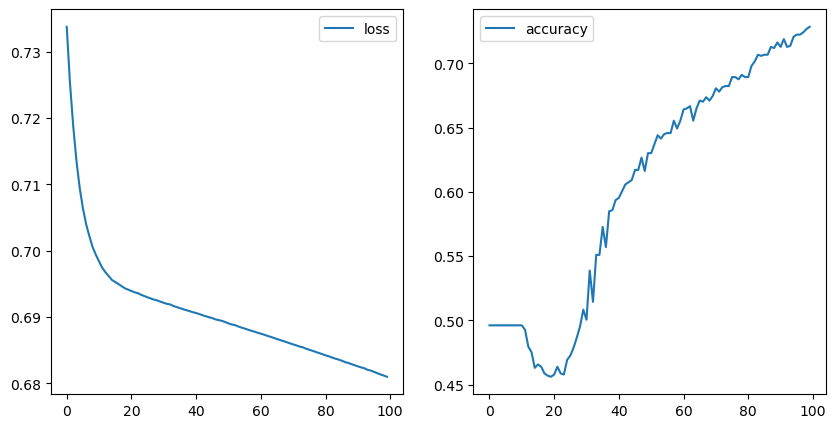

In [11]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Decrease Batch Size

In [14]:
model = Sequential()

model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# decrease batch size
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=None, verbose=0)

2022-09-09 12:09:53.694481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


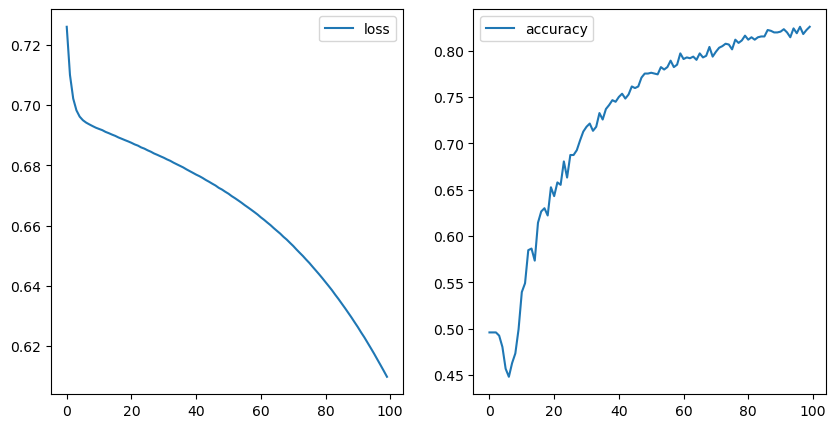

In [15]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Both - Done above for NONE batch size

In [16]:
model = Sequential()

model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# increase epochs decrease batch size
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=10, verbose=1)

Epoch 1/100
 19/115 [===>..........................] - ETA: 0s - loss: 0.7233 - accuracy: 0.5158

2022-09-09 12:11:24.021486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - 1s 7ms/step - loss: 0.7117 - accuracy: 0.4961
Epoch 2/100
115/115 [==============================] - 1s 6ms/step - loss: 0.6964 - accuracy: 0.4691
Epoch 3/100
115/115 [==============================] - 1s 6ms/step - loss: 0.6936 - accuracy: 0.5004
Epoch 4/100
115/115 [==============================] - 1s 6ms/step - loss: 0.6922 - accuracy: 0.5527
Epoch 5/100
115/115 [==============================] - 1s 6ms/step - loss: 0.6907 - accuracy: 0.5892
Epoch 6/100
115/115 [==============================] - 1s 6ms/step - loss: 0.6892 - accuracy: 0.5692
Epoch 7/100
115/115 [==============================] - 1s 6ms/step - loss: 0.6877 - accuracy: 0.6301
Epoch 8/100
115/115 [==============================] - 1s 6ms/step - loss: 0.6861 - accuracy: 0.6440
Epoch 9/100
115/115 [==============================] - 1s 6ms/step - loss: 0.6845 - accuracy: 0.6414
Epoch 10/100
115/115 [==============================] - 1s 6ms/step - loss: 0.6830 - accuracy: 0.6963
E

115/115 [==============================] - 1s 6ms/step - loss: 0.2891 - accuracy: 0.8895
Epoch 82/100
115/115 [==============================] - 1s 6ms/step - loss: 0.2866 - accuracy: 0.8903
Epoch 83/100
115/115 [==============================] - 1s 6ms/step - loss: 0.2845 - accuracy: 0.8895
Epoch 84/100
115/115 [==============================] - 1s 6ms/step - loss: 0.2823 - accuracy: 0.8912
Epoch 85/100
115/115 [==============================] - 1s 6ms/step - loss: 0.2793 - accuracy: 0.8938
Epoch 86/100
115/115 [==============================] - 1s 6ms/step - loss: 0.2783 - accuracy: 0.8903
Epoch 87/100
115/115 [==============================] - 1s 6ms/step - loss: 0.2762 - accuracy: 0.8947
Epoch 88/100
115/115 [==============================] - 1s 6ms/step - loss: 0.2744 - accuracy: 0.8956
Epoch 89/100
115/115 [==============================] - 1s 6ms/step - loss: 0.2724 - accuracy: 0.8921
Epoch 90/100
115/115 [==============================] - 1s 6ms/step - loss: 0.2707 - accuracy: 

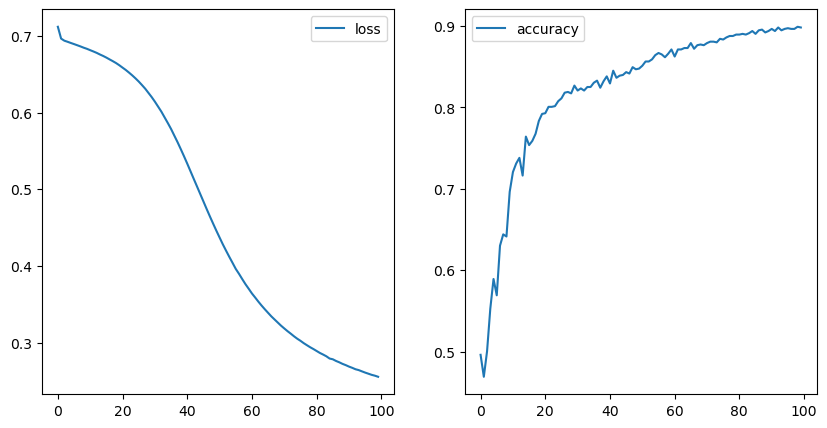

In [17]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Use Relu

In [18]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs, decrease batchsize

results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=10, verbose=0)


2022-09-09 12:14:32.439193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


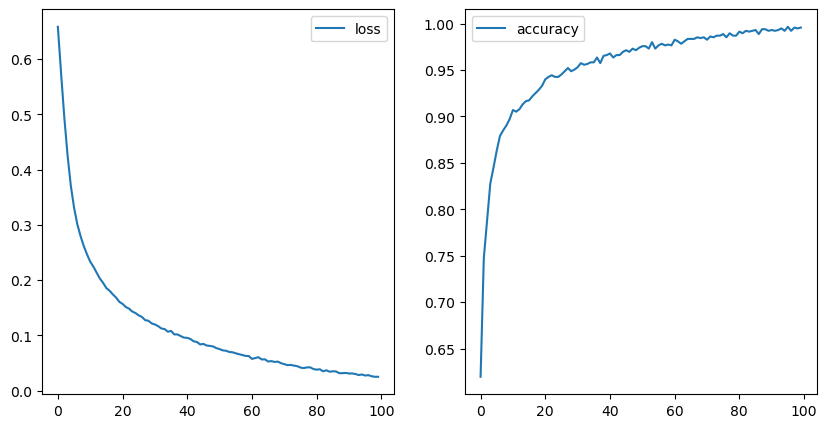

In [19]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### All of it (epochs, batch, relu)

In [ ]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs




In [ ]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Side note: learning rate

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/75


/Users/charlielosche/miniforge3/envs/enf_tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
2022-09-09 12:17:34.250476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - 1s 6ms/step - loss: 0.6634 - accuracy: 0.6110
Epoch 2/75
115/115 [==============================] - 1s 6ms/step - loss: 0.5851 - accuracy: 0.7372
Epoch 3/75
115/115 [==============================] - 1s 6ms/step - loss: 0.5135 - accuracy: 0.7737
Epoch 4/75
115/115 [==============================] - 1s 6ms/step - loss: 0.4442 - accuracy: 0.8181
Epoch 5/75
115/115 [==============================] - 1s 6ms/step - loss: 0.3922 - accuracy: 0.8399
Epoch 6/75
115/115 [==============================] - 1s 6ms/step - loss: 0.3508 - accuracy: 0.8547
Epoch 7/75
115/115 [==============================] - 1s 6ms/step - loss: 0.3188 - accuracy: 0.8695
Epoch 8/75
115/115 [==============================] - 1s 6ms/step - loss: 0.2940 - accuracy: 0.8842
Epoch 9/75
115/115 [==============================] - 1s 6ms/step - loss: 0.2762 - accuracy: 0.8912
Epoch 10/75
115/115 [==============================] - 1s 6ms/step - loss: 0.2592 - accuracy: 0.8903
Epoch 11/7

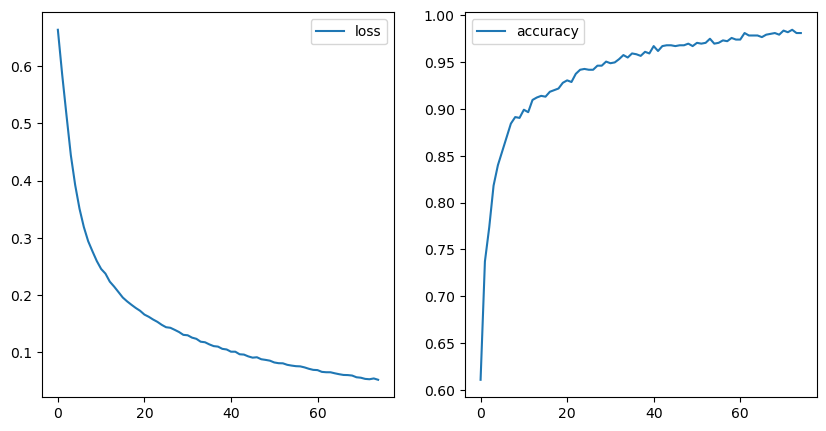

In [21]:
model = Sequential()

sgd = SGD(lr=.009)


model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=75, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();


### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

2022-09-09 12:21:40.987433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-09 12:21:42.427443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


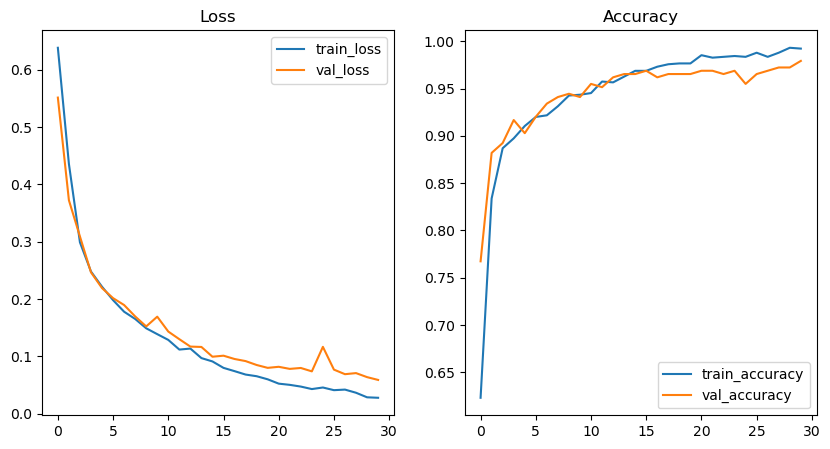

In [24]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE
results = model.fit(X_pure_train, y_pure_train, validation_data=(X_val, y_val), epochs=30, batch_size=10, verbose=0)


train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [25]:
results.history['val_accuracy'][-1]

0.9791666865348816

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [26]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x2a9772d60> does not.

In [27]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [28]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=10,
                                          batch_size=32,
                                          verbose=2)

/var/folders/tv/w6v8s7sx38q5glg08jvjkmtm0000gn/T/ipykernel_14694/348061558.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = scikit_learn.KerasClassifier(build_model,


In [29]:
type(keras_model)

keras.wrappers.scikit_learn.KerasClassifier

In [30]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

Epoch 1/10


2022-09-09 12:24:32.560585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 - 1s - loss: 0.7053 - accuracy: 0.5114 - 598ms/epoch - 21ms/step
Epoch 2/10
29/29 - 0s - loss: 0.6296 - accuracy: 0.6638 - 170ms/epoch - 6ms/step
Epoch 3/10
29/29 - 0s - loss: 0.5656 - accuracy: 0.7465 - 169ms/epoch - 6ms/step
Epoch 4/10
29/29 - 0s - loss: 0.4920 - accuracy: 0.8063 - 167ms/epoch - 6ms/step
Epoch 5/10
29/29 - 0s - loss: 0.4119 - accuracy: 0.8509 - 183ms/epoch - 6ms/step
Epoch 6/10
29/29 - 0s - loss: 0.3514 - accuracy: 0.8553 - 181ms/epoch - 6ms/step
Epoch 7/10
29/29 - 0s - loss: 0.2990 - accuracy: 0.8857 - 175ms/epoch - 6ms/step
Epoch 8/10
29/29 - 0s - loss: 0.2683 - accuracy: 0.8977 - 177ms/epoch - 6ms/step
Epoch 9/10
29/29 - 0s - loss: 0.2404 - accuracy: 0.9010 - 169ms/epoch - 6ms/step
Epoch 10/10
29/29 - 0s - loss: 0.2209 - accuracy: 0.9086 - 163ms/epoch - 6ms/step


2022-09-09 12:24:34.616439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 - 0s - loss: 0.2541 - accuracy: 0.9000 - 285ms/epoch - 36ms/step
Epoch 1/10


2022-09-09 12:24:35.284176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 - 1s - loss: 0.7075 - accuracy: 0.4984 - 739ms/epoch - 25ms/step
Epoch 2/10
29/29 - 0s - loss: 0.6236 - accuracy: 0.6453 - 183ms/epoch - 6ms/step
Epoch 3/10
29/29 - 0s - loss: 0.5638 - accuracy: 0.7399 - 178ms/epoch - 6ms/step
Epoch 4/10
29/29 - 0s - loss: 0.4948 - accuracy: 0.8096 - 181ms/epoch - 6ms/step
Epoch 5/10
29/29 - 0s - loss: 0.4198 - accuracy: 0.8531 - 171ms/epoch - 6ms/step
Epoch 6/10
29/29 - 0s - loss: 0.3512 - accuracy: 0.8727 - 171ms/epoch - 6ms/step
Epoch 7/10
29/29 - 0s - loss: 0.3004 - accuracy: 0.8803 - 167ms/epoch - 6ms/step
Epoch 8/10
29/29 - 0s - loss: 0.2679 - accuracy: 0.8912 - 172ms/epoch - 6ms/step
Epoch 9/10
29/29 - 0s - loss: 0.2450 - accuracy: 0.8988 - 176ms/epoch - 6ms/step
Epoch 10/10
29/29 - 0s - loss: 0.2208 - accuracy: 0.9075 - 171ms/epoch - 6ms/step
8/8 - 0s - loss: 0.2440 - accuracy: 0.8783 - 146ms/epoch - 18ms/step
Epoch 1/10


2022-09-09 12:24:37.289732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-09 12:24:37.614021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 - 1s - loss: 0.7043 - accuracy: 0.5092 - 509ms/epoch - 18ms/step
Epoch 2/10
29/29 - 0s - loss: 0.6350 - accuracy: 0.6768 - 173ms/epoch - 6ms/step
Epoch 3/10
29/29 - 0s - loss: 0.5840 - accuracy: 0.7106 - 167ms/epoch - 6ms/step
Epoch 4/10
29/29 - 0s - loss: 0.5169 - accuracy: 0.7748 - 177ms/epoch - 6ms/step
Epoch 5/10
29/29 - 0s - loss: 0.4383 - accuracy: 0.8324 - 185ms/epoch - 6ms/step
Epoch 6/10
29/29 - 0s - loss: 0.3612 - accuracy: 0.8662 - 186ms/epoch - 6ms/step
Epoch 7/10
29/29 - 0s - loss: 0.3053 - accuracy: 0.8814 - 178ms/epoch - 6ms/step
Epoch 8/10
29/29 - 0s - loss: 0.2686 - accuracy: 0.8890 - 188ms/epoch - 6ms/step
Epoch 9/10
29/29 - 0s - loss: 0.2447 - accuracy: 0.9010 - 186ms/epoch - 6ms/step
Epoch 10/10
29/29 - 0s - loss: 0.2301 - accuracy: 0.9119 - 188ms/epoch - 6ms/step
8/8 - 0s - loss: 0.2147 - accuracy: 0.9174 - 160ms/epoch - 20ms/step
Epoch 1/10


2022-09-09 12:24:39.670151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-09 12:24:40.009315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 - 1s - loss: 0.7126 - accuracy: 0.5005 - 529ms/epoch - 18ms/step
Epoch 2/10
29/29 - 0s - loss: 0.6316 - accuracy: 0.6355 - 179ms/epoch - 6ms/step
Epoch 3/10
29/29 - 0s - loss: 0.5702 - accuracy: 0.7160 - 165ms/epoch - 6ms/step
Epoch 4/10
29/29 - 0s - loss: 0.5005 - accuracy: 0.7780 - 163ms/epoch - 6ms/step
Epoch 5/10
29/29 - 0s - loss: 0.4280 - accuracy: 0.8346 - 175ms/epoch - 6ms/step
Epoch 6/10
29/29 - 0s - loss: 0.3746 - accuracy: 0.8400 - 163ms/epoch - 6ms/step
Epoch 7/10
29/29 - 0s - loss: 0.3226 - accuracy: 0.8749 - 168ms/epoch - 6ms/step
Epoch 8/10
29/29 - 0s - loss: 0.2857 - accuracy: 0.8945 - 167ms/epoch - 6ms/step
Epoch 9/10
29/29 - 0s - loss: 0.2737 - accuracy: 0.8847 - 168ms/epoch - 6ms/step
Epoch 10/10
29/29 - 0s - loss: 0.2548 - accuracy: 0.8912 - 167ms/epoch - 6ms/step
8/8 - 0s - loss: 0.2327 - accuracy: 0.9130 - 160ms/epoch - 20ms/step
Epoch 1/10


2022-09-09 12:24:41.957087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-09 12:24:42.289295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 - 1s - loss: 0.7026 - accuracy: 0.5228 - 533ms/epoch - 18ms/step
Epoch 2/10
29/29 - 0s - loss: 0.6266 - accuracy: 0.6728 - 168ms/epoch - 6ms/step
Epoch 3/10
29/29 - 0s - loss: 0.5637 - accuracy: 0.7337 - 169ms/epoch - 6ms/step
Epoch 4/10
29/29 - 0s - loss: 0.4883 - accuracy: 0.8076 - 168ms/epoch - 6ms/step
Epoch 5/10
29/29 - 0s - loss: 0.4098 - accuracy: 0.8402 - 174ms/epoch - 6ms/step
Epoch 6/10
29/29 - 0s - loss: 0.3436 - accuracy: 0.8707 - 170ms/epoch - 6ms/step
Epoch 7/10
29/29 - 0s - loss: 0.2949 - accuracy: 0.8870 - 173ms/epoch - 6ms/step
Epoch 8/10
29/29 - 0s - loss: 0.2626 - accuracy: 0.8913 - 176ms/epoch - 6ms/step
Epoch 9/10
29/29 - 0s - loss: 0.2381 - accuracy: 0.9022 - 180ms/epoch - 6ms/step
Epoch 10/10
29/29 - 0s - loss: 0.2200 - accuracy: 0.9087 - 181ms/epoch - 6ms/step


2022-09-09 12:24:44.287974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 - 0s - loss: 0.2670 - accuracy: 0.9039 - 308ms/epoch - 38ms/step


array([0.90000004, 0.87826091, 0.91739136, 0.91304356, 0.90393013])

## [Regularization](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer)

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

2022-09-09 12:31:52.175785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-09 12:31:53.189365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


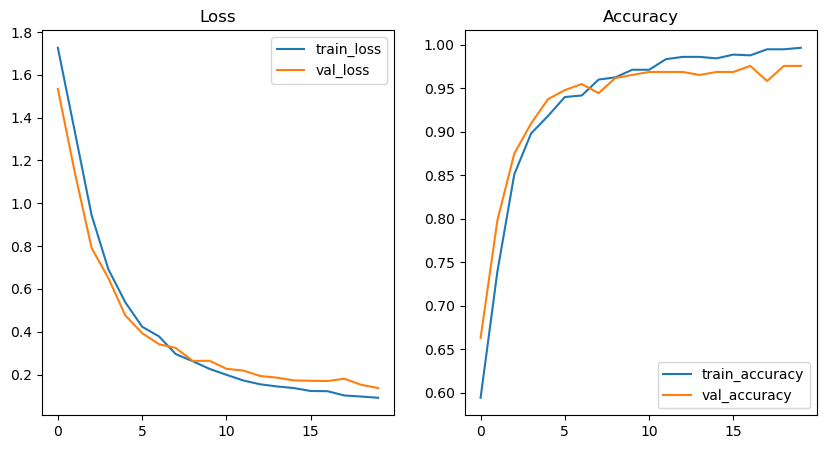

In [31]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu',kernel_regularizer=l2(l=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

Adding L2 to multiple layers:

2022-09-09 12:31:59.630429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-09 12:32:00.438828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


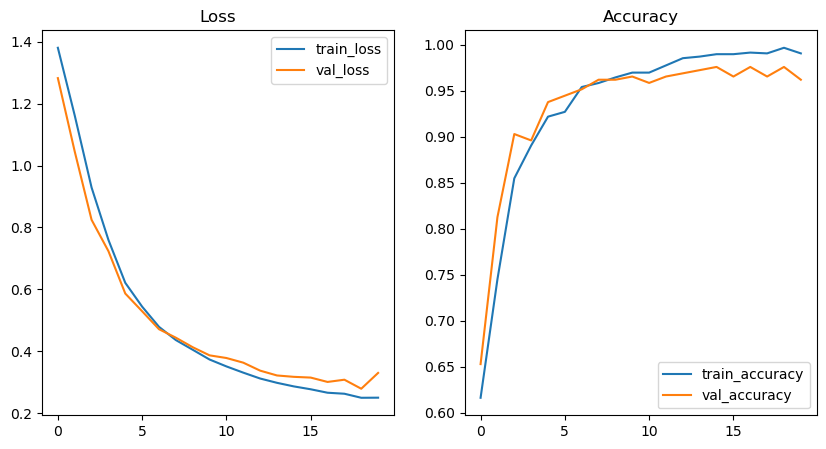

In [32]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

2022-09-09 12:36:23.169131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-09 12:36:24.262857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


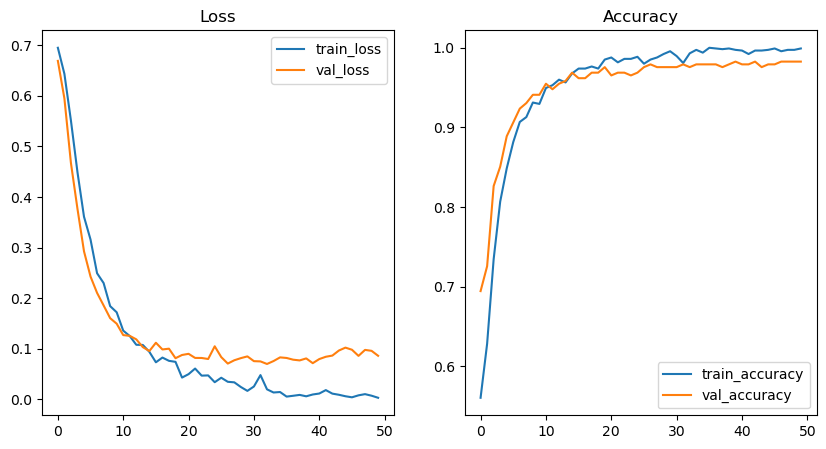

In [33]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [34]:
results.history['val_accuracy'][-1]

0.9826388955116272

2022-09-09 12:37:04.640493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-09 12:37:05.357326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


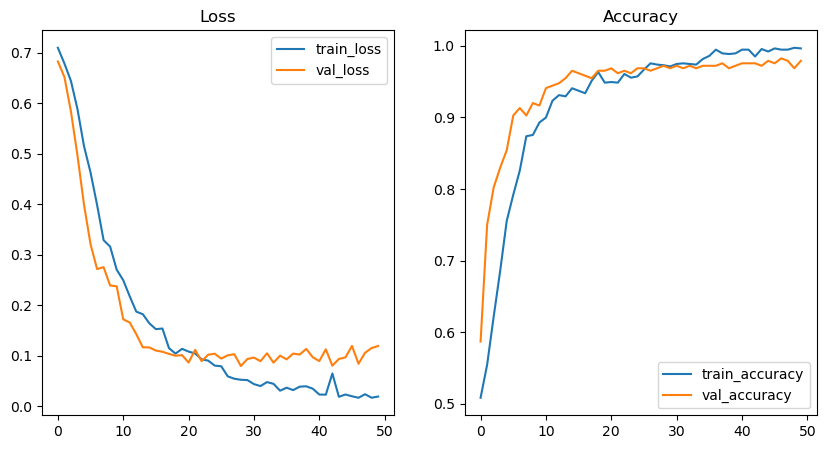

In [35]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [36]:
results.history['val_accuracy'][-1]

0.9791666865348816

2022-09-09 12:37:43.582388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-09 12:37:44.326856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


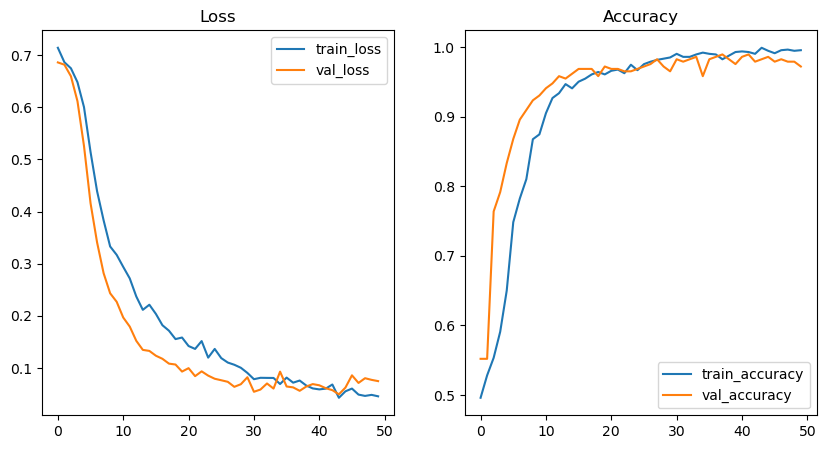

In [37]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [38]:
results.history['val_accuracy'][-1]

0.9722222089767456

# Since the graphs show that Accuracy and loss level out after 15-ish rounds, we don't need to get to 50 epochs - use early stopping

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

2022-09-09 12:46:34.896239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-09 12:46:35.586476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2: early stopping


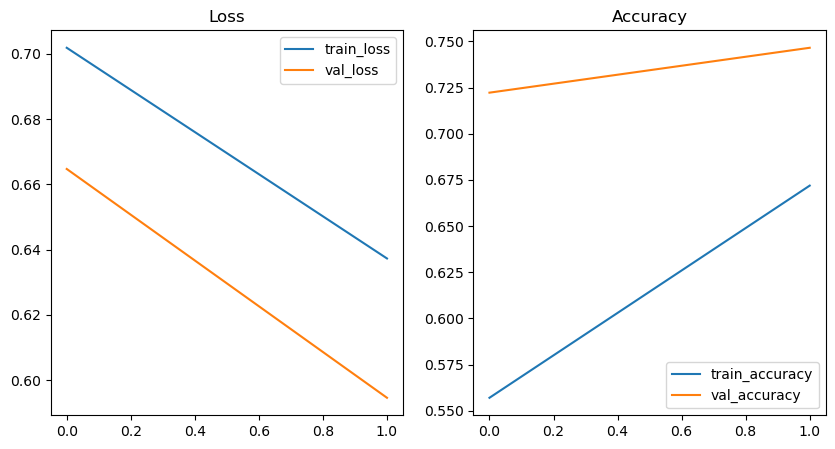

In [42]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

# Adding Patience makes sure the model stops early, but not run through all of the listed epochs


2022-09-09 12:47:37.079969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-09 12:47:38.136789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 28: early stopping


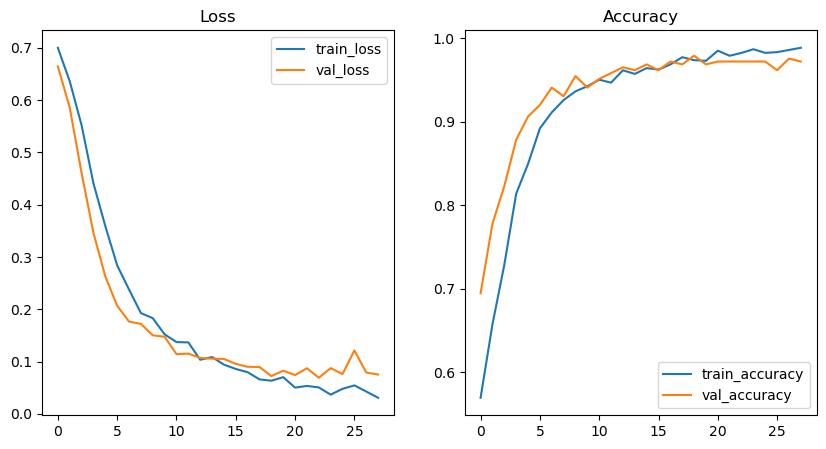

In [43]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min',
                           patience=5)

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [44]:
results.history['val_accuracy'][-1]

0.9722222089767456

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [45]:
digits = load_digits()
X = digits.data
y = digits.target

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [47]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [48]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [49]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50


2022-09-09 12:55:58.278808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - ETA: 0s - loss: 2.1349 - accuracy: 0.1993

2022-09-09 12:56:00.220441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - 2s 13ms/step - loss: 2.1349 - accuracy: 0.1993 - val_loss: 2.0261 - val_accuracy: 0.2917
Epoch 2/50
115/115 [==============================] - 1s 10ms/step - loss: 1.8456 - accuracy: 0.4064 - val_loss: 1.7628 - val_accuracy: 0.4097
Epoch 3/50
115/115 [==============================] - 1s 10ms/step - loss: 1.5595 - accuracy: 0.5222 - val_loss: 1.4912 - val_accuracy: 0.5035
Epoch 4/50
115/115 [==============================] - 1s 11ms/step - loss: 1.2578 - accuracy: 0.6519 - val_loss: 1.1685 - val_accuracy: 0.7014
Epoch 5/50
115/115 [==============================] - 1s 10ms/step - loss: 0.9705 - accuracy: 0.7833 - val_loss: 0.9100 - val_accuracy: 0.7604
Epoch 6/50
115/115 [==============================] - 1s 10ms/step - loss: 0.7604 - accuracy: 0.8207 - val_loss: 0.7210 - val_accuracy: 0.8229
Epoch 7/50
115/115 [==============================] - 1s 10ms/step - loss: 0.6146 - accuracy: 0.8451 - val_loss: 0.6083 - val_accuracy: 0.8368
Epoch 8/50

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [50]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

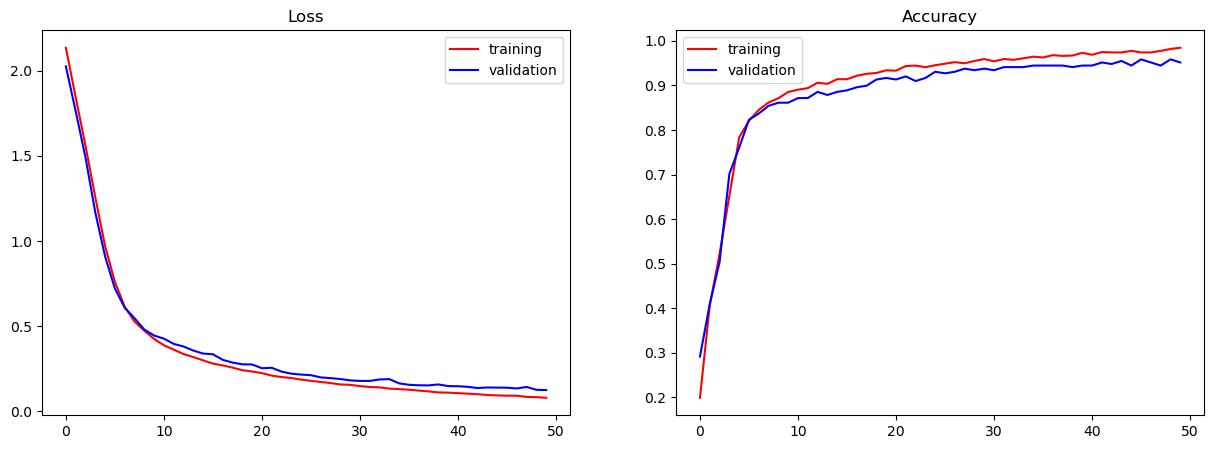

In [51]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)

ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.


In [52]:
history['val_accuracy'][-1]

0.9513888955116272

In [53]:
history['accuracy'][-1]

0.9843342304229736

In [ ]:
np.argmax()

In [54]:
model.predict(X_test)[0]

12/12 [==============================] - 0s 3ms/step


2022-09-09 13:00:26.683310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([1.40599313e-05, 1.44650457e-07, 6.38139444e-14, 1.12059145e-13,
       4.52720997e-06, 3.74661397e-07, 9.99968767e-01, 7.54011518e-14,
       3.28792498e-06, 8.77732055e-06], dtype=float32)

In [57]:
np.argmax(model.predict(X_test)[0])

12/12 [==============================] - 0s 2ms/step


6